# **Data import**

In [175]:
import pandas as pd
import requests
from io import StringIO
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

resp = requests.get('https://k-copart-car-price-prediction.s3.eu-north-1.amazonaws.com/data.csv')

if resp.status_code == 200:
  data = resp.text
else:
  print("can't fetch data")
  exit()

df = pd.read_csv(StringIO(data))

# **Data cleanup and datatype conversions**

Drop unused columns:

In [176]:
df = df[df.Final_bid != 0]
df = df.drop(['Sold', 'Make', 'Engine', 'Special Note', 'Interior', 'Make', 'Manufactured In', 'Exterior'], axis=1)

Remove Duplicates:

In [177]:
df = df.drop_duplicates()
df[df.duplicated()]
df.shape

(721, 25)

Clean the data:

In [178]:
df = df[df.Odometer_km != 'unknown)']
df = df[df.Model != 'All Models']
df = df[df.Cylinders != 'All']
df = df[df.Eng_L != 'U']

Data types conversions:

In [179]:
df.Model = df.Model.str.title()

df['Auction_date'] = pd.to_datetime(df['Auction_date'])

to_num = ['Year', 'Final_bid', 'Cylinders', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost', 'Eng_L', 'Eng_HP']

# df.loc[208]
for _ in to_num:
  df[_] = pd.to_numeric(df[_])

Cleanup Actual cash value == 0 and Estimated repair cost

# **Dataset stats**

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 662 entries, 0 to 733
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Final_bid              662 non-null    int64         
 1   Seller                 662 non-null    object        
 2   Auction_date           662 non-null    datetime64[ns]
 3   Year                   662 non-null    int64         
 4   vin                    662 non-null    object        
 5   Loss                   662 non-null    object        
 6   Primary damage         662 non-null    object        
 7   Secondary damage       661 non-null    object        
 8   Start code             662 non-null    object        
 9   Key                    662 non-null    object        
 10  Body Style             290 non-null    object        
 11  Vehicle Class          152 non-null    object        
 12  Model                  662 non-null    object        
 13  Fuel Type 

In [181]:
df.describe()

,Final_bid,Auction_date,Year,Cylinders,Odometer_km,Actual_cash_value,Estimated_repair_cost,Eng_L,Eng_HP
count,662.00,662,662.00,159.00,662.00,662.00,662.00,661.00,159.00
mean,"4,917.39",2024-06-02 05:06:42.416918528,"2,013.16",4.52,"222,703.67","12,060.33","6,487.76",2.61,177.38
min,2.00,2024-05-30 00:00:00,"2,000.00",4.00,"1,048.00",0.00,0.00,1.50,73.00
25%,"1,400.00",2024-06-01 00:00:00,"2,008.00",4.00,"111,805.75","2,925.00",0.00,1.80,132.00
50%,"3,050.00",2024-06-03 00:00:00,"2,013.00",4.00,"215,366.00","9,469.00",0.00,2.50,176.00
75%,"6,500.00",2024-06-03 00:00:00,"2,018.00",4.00,"306,900.50","18,378.25","12,351.25",3.30,203.00
max,"30,000.00",2024-06-03 00:00:00,"2,024.00",8.00,"788,968.00","60,375.00","53,390.00",5.70,381.00
std,"5,203.36",NaN,6.02,1.06,"135,156.02","11,454.24","8,711.75",0.90,62.14


# **Data analysis**




## Actual cash value and Estimated repair cost

In [182]:
print(f"[ACV = 0]: {(df['Actual_cash_value'] == 0).sum()}")
print(f"[ERC = 0]: {(df['Estimated_repair_cost'] == 0).sum()}")

[ACV = 0]: 148
[ERC = 0]: 352


Since for most cases there's no good explanation why Actual_cash_value = 0, it makes sense to clean up these rows so that other predictions will be more accurate.
Makes sense to keep Estimated repair cost = 0 since it seem to have an explanation (e.g. when it's not clear what needs to be repaired)

In [183]:
df = df[df['Actual_cash_value'] != 0]
print(f"[ACV = 0]: {(df['Actual_cash_value'] == 0).sum()}")
print(f"[ERC = 0]: {(df['Estimated_repair_cost'] == 0).sum()}")
print(df.shape)

[ACV = 0]: 0
[ERC = 0]: 204
(514, 25)


In [184]:
sctr = px.scatter(df, x = 'Actual_cash_value', y = "Final_bid", title = "Actual cash value vs bid price", hover_name = df.index)

sctr.update_layout(xaxis_title = "Actual cash value", yaxis_title= "Final bid")

sctr.show()

In [185]:
sctr = px.scatter(df, y = 'Final_bid', x = "Estimated_repair_cost", title = "Actual cash value vs bid price", hover_name = df.index)

sctr.update_layout(yaxis_title = "Final bid", xaxis_title= "Estimated repair cost")

sctr.show()

## Models distribution

Clean and unify models:

In [186]:
df = df[df['Model'] != 'All Models']  # clearly a mistake

df.loc[df['Model'] == '4Runner Se', 'Model'] = '4Runner'
df.loc[df['Model'] == 'Camry Sola', 'Model'] = 'Camry'
df.loc[df['Model'] == 'Grand Highlander', 'Model'] = 'Highlander'
df.loc[df['Model'] == 'Corolla Cr', 'Model'] = 'Corolla'
df.loc[df['Model'] == 'Camry Hybrid', 'Model'] = 'Camry'
df.loc[df['Model'] == 'Prius C', 'Model'] = 'Prius'
df.loc[df['Model'] == 'Avalon Hybrid', 'Model'] = 'Avalon'
df.loc[df['Model'] == 'Corolla (U.S.)', 'Model'] = 'Corolla'
df.loc[df['Model'] == 'Prius Nigh', 'Model'] = 'Prius'

In [187]:
models_df = df.groupby('Model', as_index=False).agg({'Final_bid': pd.Series.mean,
                         'Auction_date': pd.Series.count,
                        'Actual_cash_value': pd.Series.mean})

models_df = models_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

models_df

,Model,Avg_final_bid,Count,Avg_actual_cash_value
3,Camry,"3,686.78",120,"12,001.69"
4,Corolla,"4,027.63",106,"12,253.50"
8,Prius,"3,363.09",65,"12,253.34"
9,Rav4,"7,031.47",58,"19,273.98"
13,Tacoma,"9,617.11",38,"28,127.29"
6,Highlander,"9,208.69",29,"21,053.07"
0,4Runner,"10,187.50",18,"24,725.50"
14,Tundra,"10,585.00",14,"26,057.86"
16,Yaris,"2,297.50",10,"9,039.30"
10,Scion,"1,033.33",9,"7,244.33"


In [188]:
bar = px.bar(x = models_df.Model,
             y = models_df.Count,
             title='Distribution of models in dataset',
             hover_name=models_df.Model,
             color=models_df.Avg_final_bid,
             color_continuous_scale='Agsunset')

bar.update_layout(xaxis_title='Model',
yaxis_title='Amount of cars in the dataset',
coloraxis_showscale=False)

bar.show()

Range of bids by model:

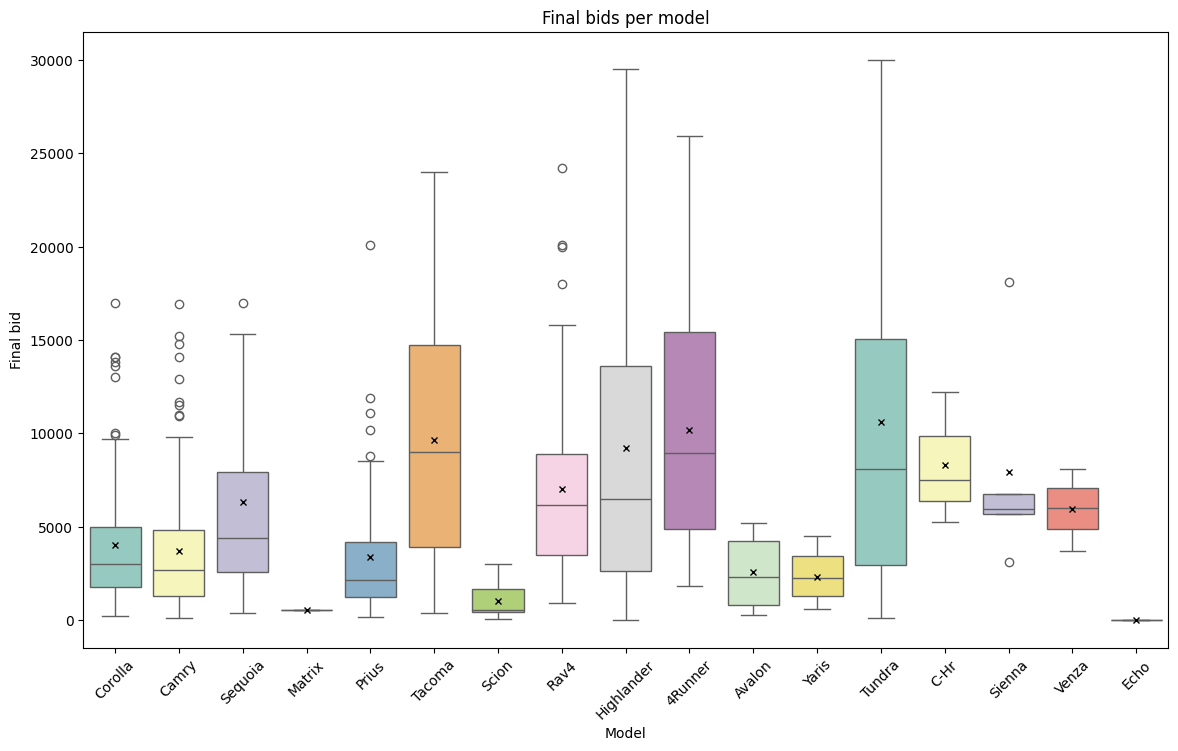

In [189]:
# box = px.box(df,
#              y='Model',
#              x='Final_bid',
#             #  notched=True,
#             #  points='all',
#              title='Final bids per model')

# # box.update_layout(yaxis=dict(type='log'))

# box.show()


plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=df,
    x='Model',
    y='Final_bid',
    palette='Set3',
    showmeans=True,
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}
)


plt.title('Final bids per model', fontsize=12)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=45)
# plt.grid(True)

plt.show()

## Distribution by Model Series

In [190]:
series_df = df.groupby('Series', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

series_df = series_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count', 'Avg_final_bid'], ascending=False)

series_df

,Series,Avg_final_bid,Count,Avg_actual_cash_value
9,LE,"3,780.56",45,"12,106.20"
21,SE,"4,523.33",15,"12,198.33"
36,XLE,"7,092.86",14,"20,465.29"
15,LIMITED,"8,737.50",6,"24,156.00"
34,TWO,"2,495.00",5,"8,331.20"
30,THREE,"1,450.00",4,"7,331.00"
33,TRD SPORT,"13,583.33",3,"35,963.00"
29,SR5 V8,"3,200.00",3,"5,723.33"
39,XLE V6,"2,266.67",3,"7,884.33"
7,II,"2,075.00",3,"6,036.67"


There seem to be not enough data in this column to make sense of it

## Distribution by damage

In [191]:
df.loc[df['Primary damage'] == 'Flood', 'Primary damage'] = 'Water / flood'

In [192]:
damage_df = df.groupby('Primary damage', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

damage_df = damage_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count', 'Avg_final_bid'], ascending=False)

damage_df

,Primary damage,Avg_final_bid,Count,Avg_actual_cash_value
4,Front end,"5,136.76",221,"15,712.49"
13,Rear,"5,754.17",66,"15,642.86"
20,Side,"6,526.61",36,"17,264.11"
0,All over,"6,918.09",34,"21,441.12"
10,Mechanical,"1,012.71",17,"6,110.59"
3,Front & rear,"4,310.00",15,"13,851.40"
9,Left side,"3,983.93",14,"13,085.86"
24,Unknown,"1,978.85",13,"5,211.46"
12,Normal wear,"5,681.25",12,"14,065.83"
17,Right side,"7,550.00",9,"20,044.78"


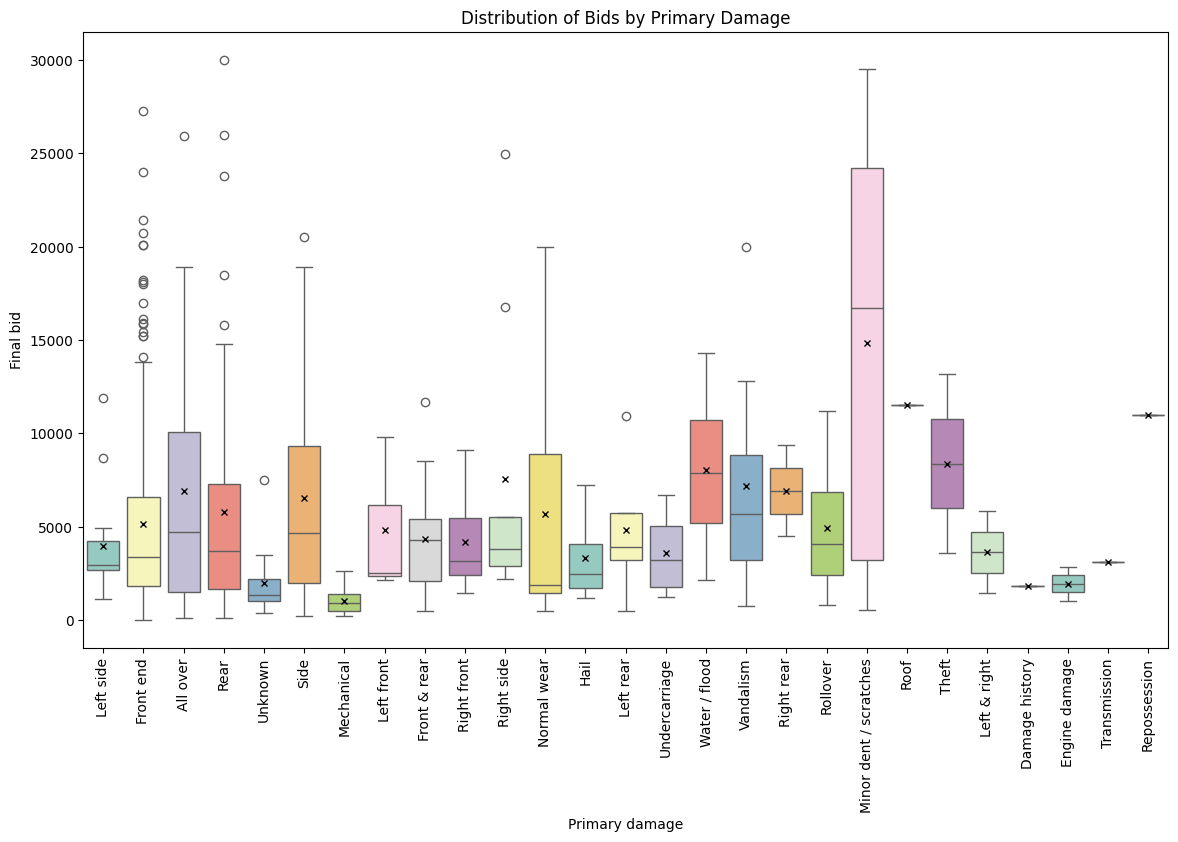

In [193]:
plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=df,
    x='Primary damage',
    y='Final_bid',
    palette='Set3',
    showmeans=True,
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}
)


plt.title('Distribution of Bids by Primary Damage', fontsize=12)
plt.xlabel('Primary damage', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=90)
# plt.grid(True)

plt.show()

<h3>Secondary damage:</h3>

In [194]:
sec_damage_df = df.groupby('Secondary damage', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

sec_damage_df = sec_damage_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

sec_damage_df

,Secondary damage,Avg_final_bid,Count,Avg_actual_cash_value
0,-,"5,617.99",278,"15,968.47"
21,Side,"5,592.31",39,"17,223.82"
6,Front end,"4,150.00",28,"13,730.14"
13,Minor dent / scratches,"5,133.04",27,"13,369.85"
26,Unknown,"4,877.78",27,"12,965.22"
15,Rear,"5,864.26",23,"19,558.09"
18,Right side,"4,145.45",11,"14,102.18"
25,Undercarriage,"5,525.00",8,"16,628.75"
12,Mechanical,"3,007.17",6,"10,064.33"
23,Suspension,"6,225.00",6,"15,790.17"


In [216]:
burst_df = df.groupby(by=['Primary damage', 'Secondary damage'], as_index=False).agg({'Final_bid': pd.Series.count})


burst_df = burst_df.rename(columns = {'Final_bid' : 'Count'})
burst_df = burst_df.sort_values('Count', ascending=False)



burst = px.sunburst(burst_df,
                    path=['Primary damage', 'Secondary damage'],
                    values='Count',
                    title='Damage types',
                   )

burst.show()

**<h2>Conclusion regarding damage:</h2>**

* Front end is amazingly popular damage
* Cars with Front end damage are cheaper than with Rear damage
* Cars with Left side damage is cheaper (and twice more frequent!) than cars with Right side damage

> Check if it makes sense to merge all Front together, all Rear together and all Side together

> Cars with "All over" and "Rollover" damages are rather expensive for unclear reason  [To be investigated]




## Distribution by Sellers

In [196]:
sellers_df = df.groupby('Seller', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

sellers_df = sellers_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

sellers_df = sellers_df[sellers_df.Count > 5]
sellers_df

,Seller,Avg_final_bid,Count,Avg_actual_cash_value
15,Insurance company,"5,067.21",132,"15,749.58"
21,Non-insurance company,"4,533.61",113,"13,015.19"
24,Progressive Casualty Insurance,"4,753.85",65,"15,543.17"
10,Farmers Insurance,"7,350.78",32,"17,733.72"
11,GEICO,"5,104.84",31,"15,535.90"
8,CSAA,"6,350.00",22,"19,007.95"
31,USAA,"7,817.11",19,"19,842.68"
25,State Farm Group Insurance,"4,258.33",18,"14,475.06"
23,Progressive,"5,776.55",11,"17,821.73"
26,State Farm Insurance,"3,530.67",9,"15,827.89"


In [197]:
sellers_df.Seller
sdf = df[df['Seller'].isin(sellers_df.Seller)]

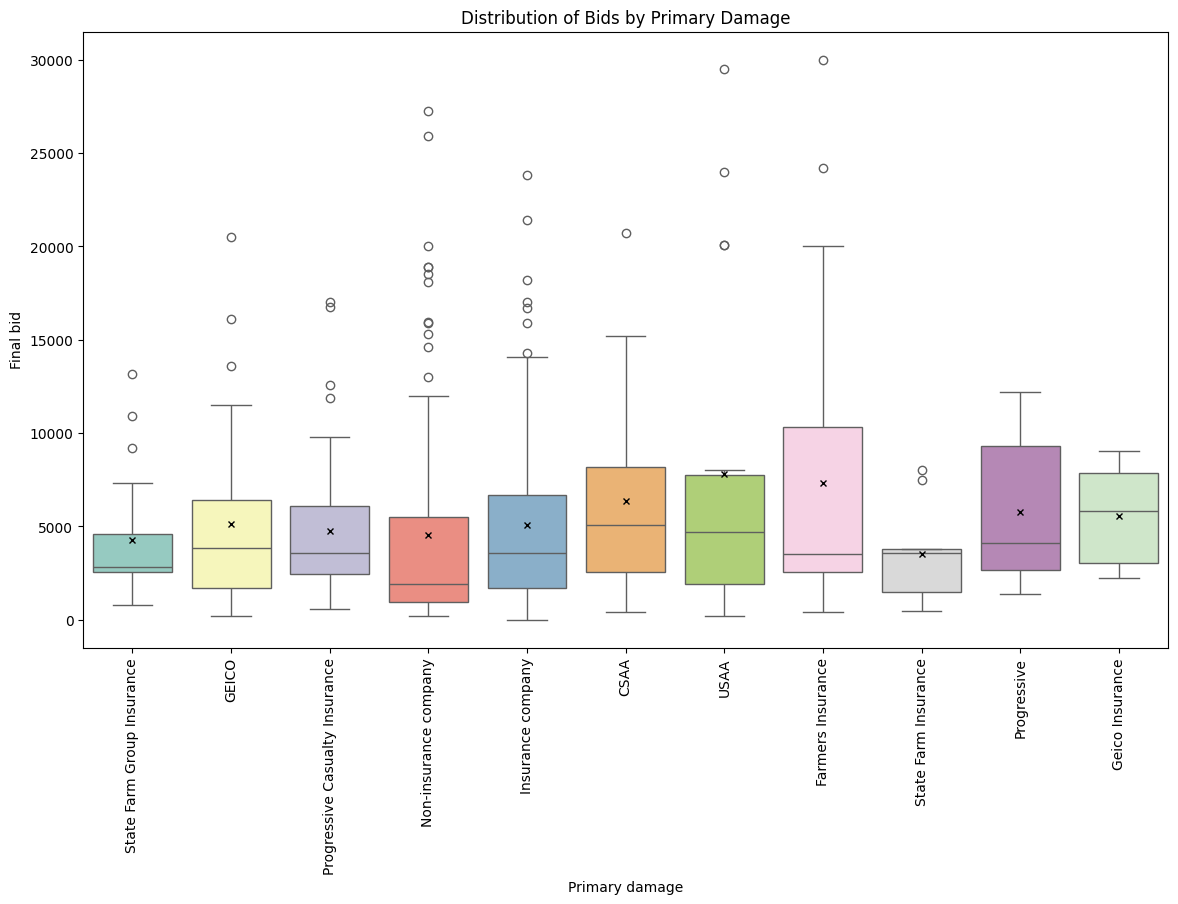

In [198]:
plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=sdf,
    x='Seller',
    y='Final_bid',
    palette='Set3',
    showmeans=True,
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}
)


plt.title('Distribution of Bids by Primary Damage', fontsize=12)
plt.xlabel('Primary damage', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=90)
# plt.grid(True)

plt.show()

**Conclusion:** taking aside sellers with very few lots, there seem to be no difference among major insurance companies.
However, 'State Farm Insurance" sells cars cheaper than everyone else. Interesting

## Distribution by Manufacturing Year

In [199]:
year_df = df.groupby('Year', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

year_df = year_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

year_df

,Year,Avg_final_bid,Count,Avg_actual_cash_value
12,2012,"2,960.94",32,"10,359.69"
22,2022,"11,360.41",32,"29,438.12"
19,2019,"9,917.74",31,"25,569.48"
14,2014,"3,798.63",30,"12,048.50"
20,2020,"7,473.37",30,"22,437.77"
17,2017,"5,336.83",29,"16,807.10"
16,2016,"5,366.96",28,"16,631.21"
10,2010,"2,048.32",28,"7,640.43"
15,2015,"4,100.00",27,"13,822.52"
18,2018,"6,792.31",26,"20,897.92"


In [200]:
hist = px.histogram(year_df,
                   x='Year',
                    y = 'Count',
                  #  color='Avg_final_bid',
                   nbins=24,
                   opacity=0.6,
                  #  barmode='overlay',
                  #  histnorm='percent',
                   marginal='box',
                    )

hist.update_layout(xaxis_title='Year',
                   yaxis_title='Count',)

hist.show()

Seem to be ± normal distribution. No surprises here

## Distribution by start code:

In [201]:
code_df = df.groupby('Start code', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

code_df = code_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

code_df

,Start code,Avg_final_bid,Count,Avg_actual_cash_value
1,Run and Drive,"5,745.48",353,"15,690.30"
2,Starts,"5,253.67",64,"17,765.53"
0,No information,"3,425.53",47,"13,433.28"
3,Stationary,"3,809.68",31,"14,229.29"


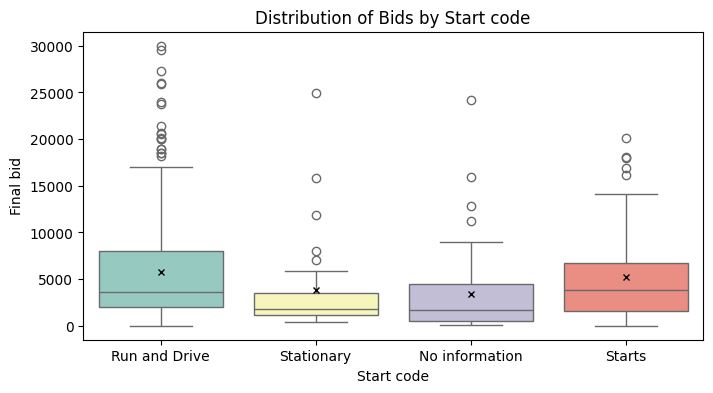

In [202]:
plt.figure(figsize=(8, 4))

box = sns.boxplot(
    data=df,
    x='Start code',
    y='Final_bid',
    palette='Set3',  # Color palette
    showmeans=True,  # Show the mean as a point
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}  # Mean marker properties
)


plt.title('Distribution of Bids by Start code', fontsize=12)
plt.xlabel('Start code', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
# plt.xticks(rotation=45)
# plt.grid(True)

plt.show()

Not much is happening here but it's clear that Stationary cars are overall cheaper than others

## Distribution by Mileage:

In [203]:
hist = px.histogram(df,
                   x='Odometer_km',
                  #  nbins=20,
                   opacity=0.6,
                  #  barmode='overlay',
                  #  histnorm='percent',

                    )

hist.update_layout(xaxis_title='Mileage',
                   yaxis_title='Count',)

hist.show()

In [204]:
sctr = px.scatter(df, x = 'Odometer_km', y = "Final_bid", title = "Actual cash value vs bid price", hover_name = df.index)

sctr.update_layout(xaxis_title = "Mileage", yaxis_title= "Final bid")

sctr.show()

Nothing unexpected here. Higher mileage = lower bid

## Distribution by Engine size

In [205]:
box = px.box(df,
             y='Final_bid',
             x='Eng_L',
             points='all',
             title='Dependency between Engine L and Final bid?')

box.show()

In [206]:
box = px.box(df,
             y='Eng_L',
            #  size = 1,
            #  x='Eng_L',
             points='all',
             title='Distribution of Engine L')

# box.update_layout(yaxis=dict(type='log'))

box.show()

## Missing keys and Manual transmission

In [207]:
print(f"Missing key: {(df[df['Key'] != 'Present']).shape[0]} cars")
print(f"Manual transmission: {(df[df['Transmission'] == 'Manual']).shape[0]} cars")

Missing key: 10 cars
Manual transmission: 11 cars


In [208]:
box = px.box(df,
             y='Final_bid',
             x='Key',
             points='all',
             title='Dependency between Missing key and Final bid?')

box.show()

In [209]:
box = px.box(df,
             y='Final_bid',
             x='Transmission',
             points='all',
             title='Dependency between Transmission and Final bid?')

box.show()

## Sale status

In [210]:
status_df = df.groupby('Sale Status', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

status_df = status_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

status_df

,Sale Status,Avg_final_bid,Count,Avg_actual_cash_value
1,On minimum bid,"6,131.43",185,"17,095.64"
2,Pure sale,"5,039.51",129,"15,645.93"
0,On approval,"7,156.91",22,"22,288.27"


In [211]:
box = px.box(df,
             y='Final_bid',
             x='Sale Status',
             points='all',
             title='Dependency between Sale Status and Final bid?')

box.show()

## Categorical data visualization

In [212]:
burst_df = df.groupby(by=['Model', 'Primary damage', 'Secondary damage','Start code'], as_index=False).agg({'Final_bid': pd.Series.count})


burst_df = burst_df.rename(columns = {'Final_bid' : 'Count'})
burst_df = burst_df.sort_values('Count', ascending=False)



burst = px.sunburst(burst_df,
                    path=['Model', 'Primary damage', 'Start code', 'Secondary damage'],
                    values='Count',
                    title='Interactive visualisation of categorical data',
                   )

burst.show()

# **Explore correlations**

Parameters interesting for price prediction:
Categorical:
* Model
* Series (a lot of missing data / not systematic)
* Primary damage
* Secondary damage
* Start code
* Key (not enough data to make sense of it)
* Transmission

Numerical:
* Year
* Cylinders (a lot of missing data)
* Odometer
* Actual cash value
* Estimated repair cost

Investigate:
* Engine size, L (a lot of missing data)
* Engine HP (a lot of missing data)

* Sale status

### evrth with evrth charts:

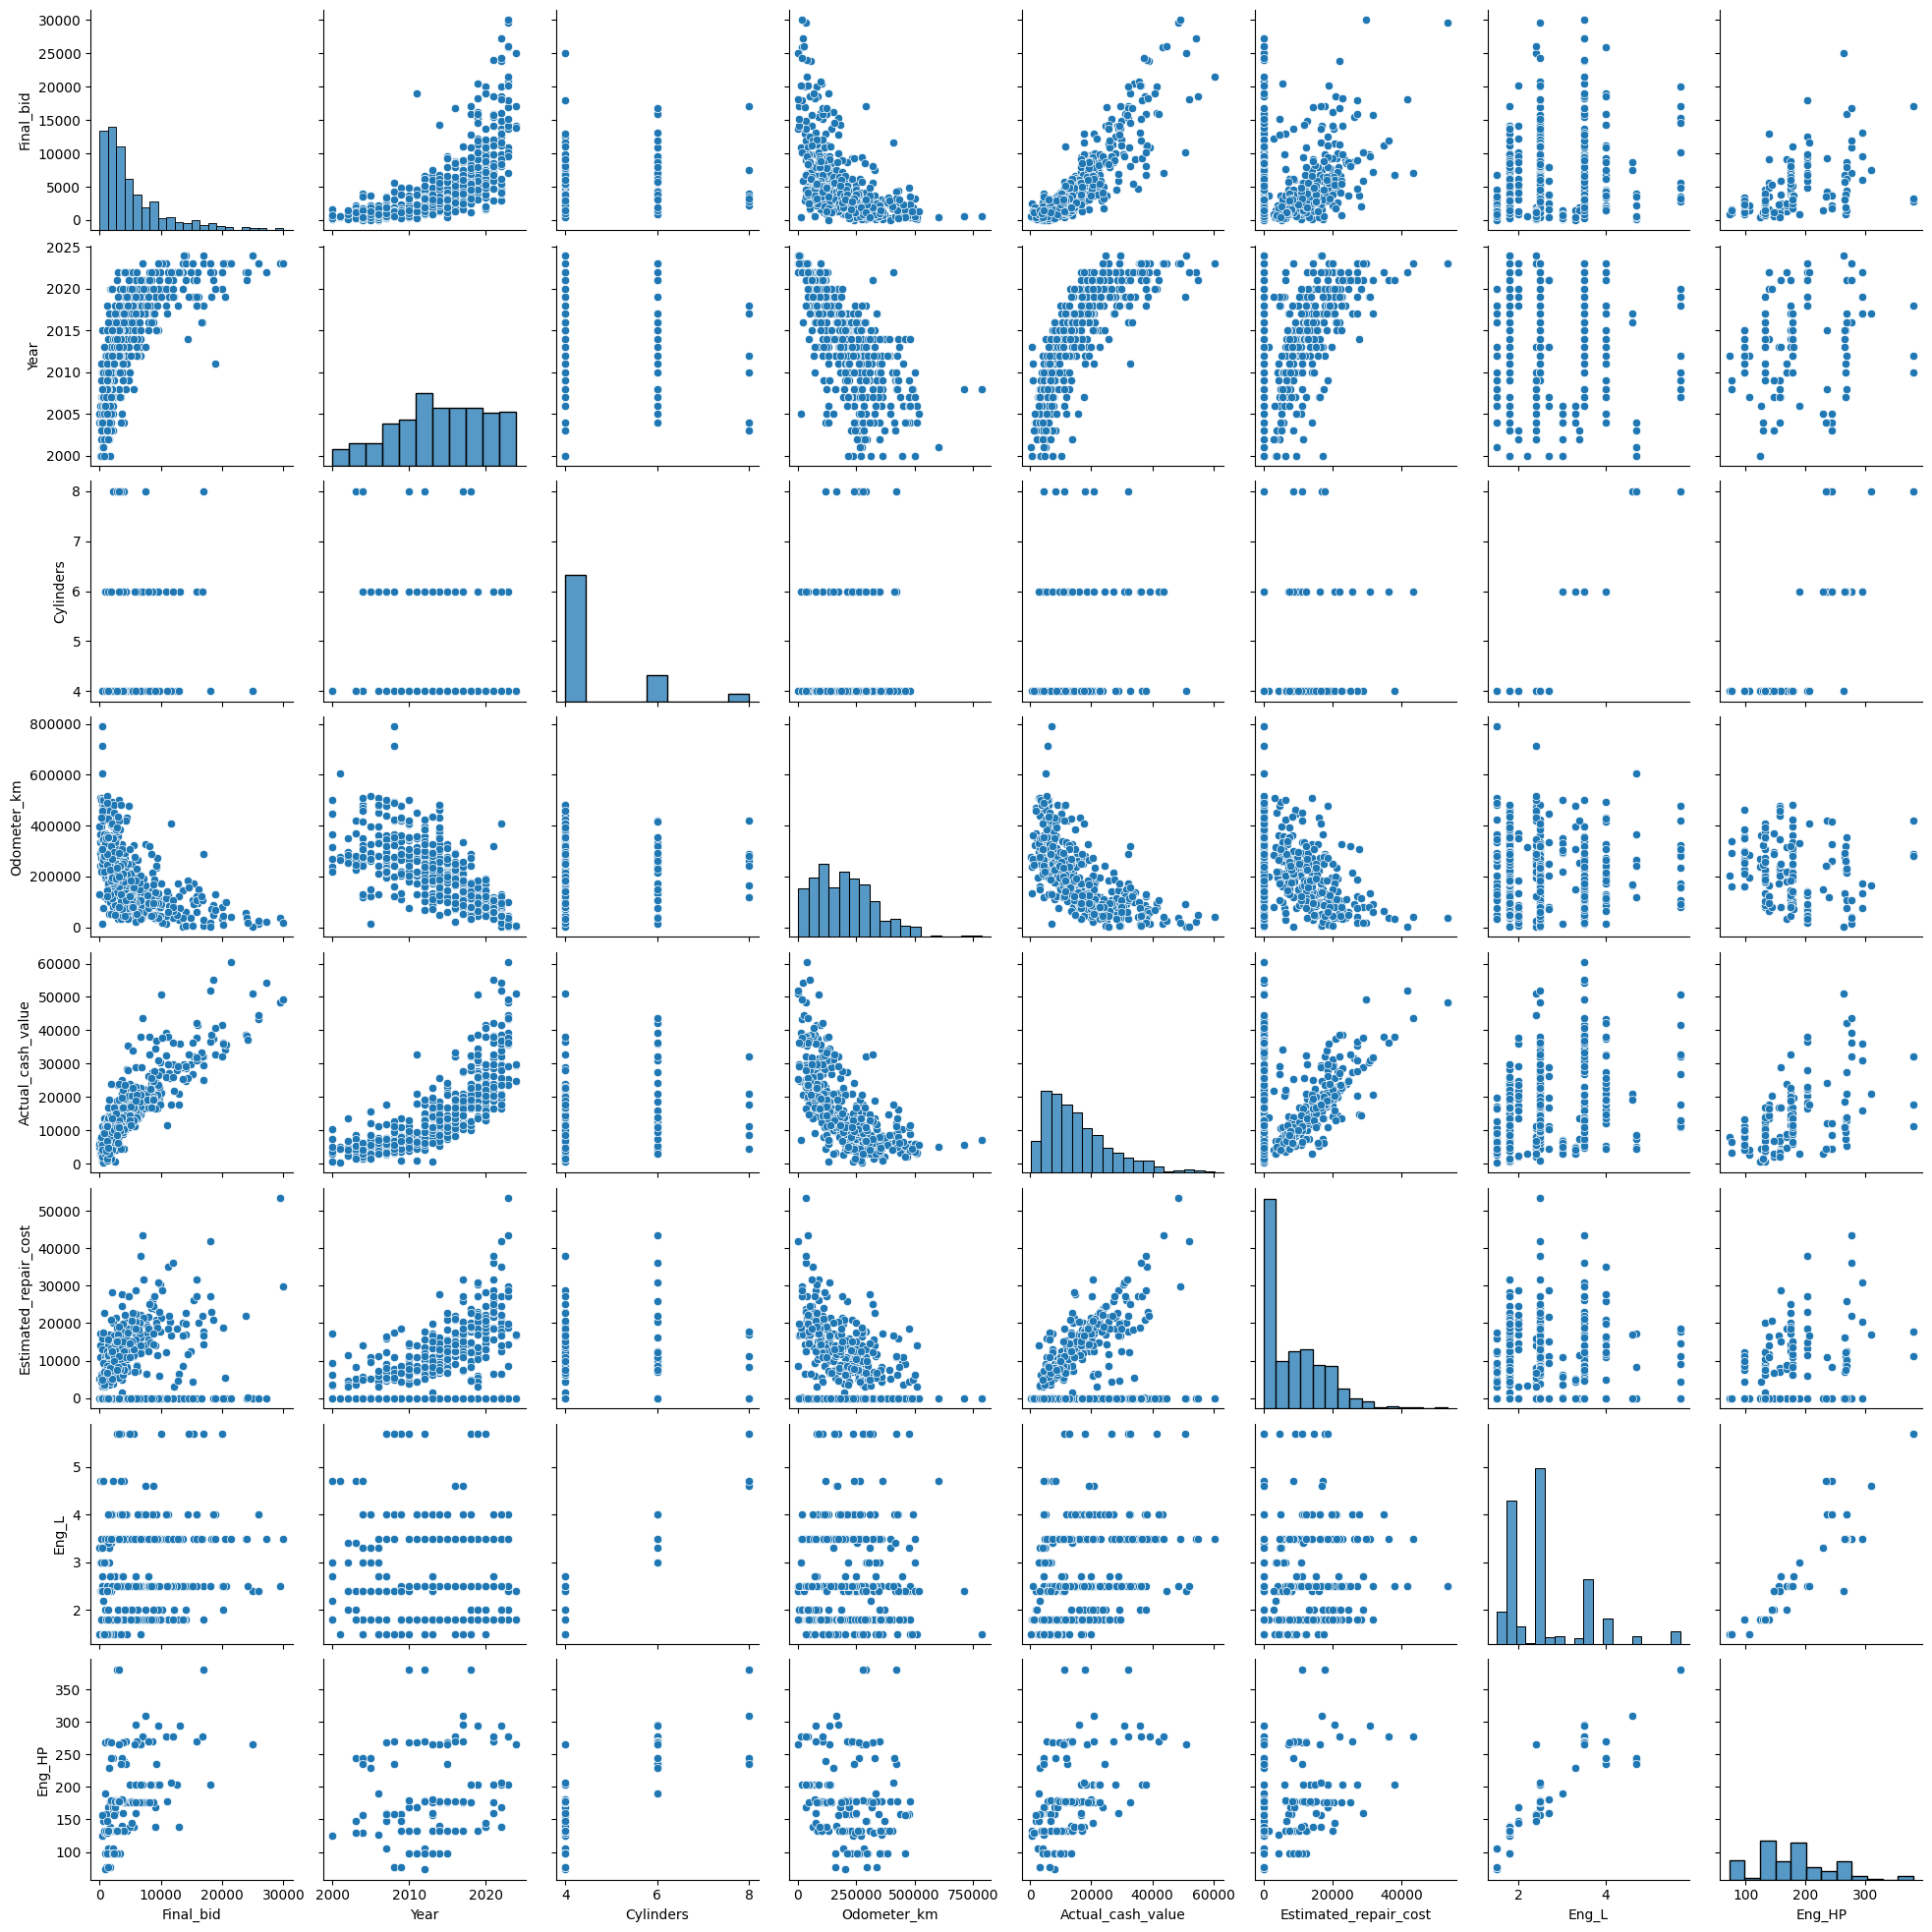

In [213]:

# sns.pairplot(df, hue='Final_bid')
sns.pairplot(df)

# **Auction price prediction**

In [226]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df[['Year', 'Primary damage', 'Secondary damage', 'Start code', 'Key', 'Model',  'Transmission', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost', 'Sale Status' ]]  # 'Eng_L', 'Eng_HP',
y = df['Final_bid']

categorical = ['Primary damage', 'Secondary damage', 'Start code', 'Model', 'Transmission', 'Sale Status']
numerical = ['Year', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost']  # , 'Eng_L', 'Eng_HP'

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])

model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Odometer_km',
                                                   'Actual_cash_value',
                                                   'Estimated_repair_cost']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Primary damage',
                                                   'Secondary damage',
                                                   'Start code', 'Model',
                                                   'Transmission',
                                                   'Sale Status'])])),
                ('model',
                 RandomForestRegressor(n_estimators=1000, random_state=42))])

Make a prediction

In [229]:
def predict_price(car_details):
    input_df = pd.DataFrame([car_details])
    prediction = pipeline.predict(input_df)
    return prediction[0]


to_be_predicted = {'Year': 2021,
                   'Primary damage': 'Front end',
                   'Secondary damage': '',
                   'Start code': 'Run and Drive',  # stationary increases price??
                   'Model': 'Corolla',
                   'Transmission': 'Automatic',
                   'Odometer_km': 100930,  # higher mileage increases price?? o_0
                   'Actual_cash_value': 35817,
                   'Estimated_repair_cost': 19817,
                   'Sale Status': 'Pure sale',
                   }

predicted_price = predict_price(to_be_predicted)
print(f'Predicted Price: ${predicted_price}')

Predicted Price: $16379.282
